In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

plt.rcParams['figure.dpi'] = 450

In [2]:
# data_dir = 'D:\\RST\\notebook\\networks\\'
# root_dir = 'D:\\RST\\notebook\\'

In [3]:
root_dir = '/Volumes/Data2/RST/notebook/'
data_dir = '/Volumes/Data2/RST/notebook/networks/'

In [4]:
period = 'AM'

In [5]:
tts = pd.read_csv(root_dir + 'TTS OD/TTS_TYPE.csv')
tts = tts.rename(columns = {'origin':'o_node', 'destination':'d_node'})

In [6]:
bc_data = pd.read_csv(data_dir + period + '/' + 'BC-' + period + '_node.csv' )
bc_data

,o_node_time,d_node_time,o_node,d_node,INT_ID,bc_single
0,1001-0-7-6,1018-0-99-99,1001,1018,13464374,1.0
1,1001-0-7-6,1018-0-99-99,1001,1018,13463942,1.0
2,1001-0-7-6,1018-0-99-99,1001,1018,13464855,1.0
3,1001-0-7-6,1018-0-99-99,1001,1018,13465571,1.0
4,1001-0-7-6,1018-0-99-99,1001,1018,13465017,1.0
...,...,...,...,...,...,...
1806943,1624-0-7-55,1525-0-99-99,1624,1525,13445095,0.0
1806944,1624-0-7-55,1525-0-99-99,1624,1525,13444537,0.0
1806945,1624-0-7-55,1525-0-99-99,1624,1525,13444084,0.0
1806946,1624-0-7-55,1525-0-99-99,1624,1525,13447347,0.0


In [7]:
bc_data['time'] = bc_data['o_node_time'].str.split('-0-', expand = True)[1]
bc_data

,o_node_time,d_node_time,o_node,d_node,INT_ID,bc_single,time
0,1001-0-7-6,1018-0-99-99,1001,1018,13464374,1.0,7-6
1,1001-0-7-6,1018-0-99-99,1001,1018,13463942,1.0,7-6
2,1001-0-7-6,1018-0-99-99,1001,1018,13464855,1.0,7-6
3,1001-0-7-6,1018-0-99-99,1001,1018,13465571,1.0,7-6
4,1001-0-7-6,1018-0-99-99,1001,1018,13465017,1.0,7-6
...,...,...,...,...,...,...,...
1806943,1624-0-7-55,1525-0-99-99,1624,1525,13445095,0.0,7-55
1806944,1624-0-7-55,1525-0-99-99,1624,1525,13444537,0.0,7-55
1806945,1624-0-7-55,1525-0-99-99,1624,1525,13444084,0.0,7-55
1806946,1624-0-7-55,1525-0-99-99,1624,1525,13447347,0.0,7-55


In [8]:
list(bc_data['time'].drop_duplicates())

['7-6', '7-23', '7-43', '7-16', '7-39', '7-55']

In [9]:
df_list = []
variability_list = []

weight_type = 'raw'

for period in ['EM','AM', 'MD', 'PM', 'EV']:
    
    bc_data = pd.read_csv(data_dir + period + '/' + 'BC-' + period + '_node.csv' )
    bc_data['time'] = bc_data['o_node_time'].str.split('-0-', expand = True)[1]

    for time_str in list(bc_data['time'].drop_duplicates()):

        bc_avg = bc_data[bc_data['time'] == time_str].copy()

        bc_avg['o_node'] = bc_avg['o_node'] - 1000
        bc_avg['d_node'] = bc_avg['d_node'] - 1000

        period_tts = tts[tts['type'] == weight_type + '_' + period.lower()]

        stop_times_od = pd.read_csv(root_dir + 'networks/' + period + '-TE-16-8.csv')
        N = len((stop_times_od['INT_ID_o'].append(stop_times_od['INT_ID_d'])).drop_duplicates())

        bc_all = bc_avg.merge(period_tts)
        bc_od = bc_all.copy()
        bc_all['weighted'] = (bc_all['bc_single'] * bc_all['total'])
        bc_all = bc_all.groupby(['INT_ID']).agg({'weighted':'sum'}).reset_index()
        bc_all['weighted'] = bc_all['weighted']/((N - 1) * (N - 2) * period_tts['total'].sum())
        bc_all['time'] = time_str

        df_list.append(bc_all)

    bc_weighted = pd.concat(df_list)

    bc_mean = bc_weighted.groupby('INT_ID').mean()[['weighted']].reset_index().rename(columns = {'weighted':'mean'})
    bc_std = bc_weighted.groupby('INT_ID').std()[['weighted']].reset_index().rename(columns = {'weighted':'std'})
    bc_max = bc_weighted.groupby('INT_ID').max()[['weighted']].reset_index().rename(columns = {'weighted':'max'})
    bc_min = bc_weighted.groupby('INT_ID').min()[['weighted']].reset_index().rename(columns = {'weighted':'min'})
    bc_range = bc_max.merge(bc_min)
    bc_range['range'] = bc_range['max'] - bc_range['min']

    bc_variability = bc_mean.merge(bc_std).merge(bc_range[['INT_ID', 'range']])
    bc_variability['cov'] = round(bc_variability['std']*100/bc_variability['mean'],3)
    bc_variability['rel_range'] = round(bc_variability['range']*100/bc_variability['mean'],3)

    bc_variability['period'] = period
    
    variability_list.append(bc_variability)

In [10]:
bc_var_df = pd.concat(variability_list)
bc_var_df

,INT_ID,mean,std,range,cov,rel_range,period
0,100,4.222603e-09,9.589018e-10,3.026691e-09,22.709,71.678,EM
1,101,5.868707e-09,1.452817e-09,3.928429e-09,24.755,66.939,EM
2,102,9.315443e-09,1.968840e-09,5.657466e-09,21.135,60.732,EM
3,103,8.266396e-09,2.204468e-09,5.290338e-09,26.668,63.998,EM
4,104,1.257338e-08,4.662320e-09,1.304962e-08,37.081,103.788,EM
...,...,...,...,...,...,...,...
4110,30104484,3.385253e-10,2.357035e-10,8.905459e-10,69.627,263.066,EV
4111,30109241,1.902048e-09,5.663657e-10,2.321683e-09,29.777,122.062,EV
4112,30112870,2.501777e-10,1.383512e-10,5.787139e-10,55.301,231.321,EV
4113,30113231,4.346361e-11,3.910840e-11,1.355232e-10,89.980,311.808,EV


## Assigning Stations to Service

In [11]:
inner_to_stn = [100,101,102,103,104,105,106,107,108,109,110,111,112,
                151,152,153,154,155,1561,57,158,159,
               203,204,205,206,207,208,209,210,211,212,213,214,215,
                216,217,218,219,220,221,222,223,224]

streetcar_routes = [501,502,503,504,505,506,509,510,511,512,514]

frequent_routes = [7,22,24,25,29,32,34,35,36,39,43,44,47,
                   52,53,54,60,63,69,70,72,76,84,85,86,87,89,94,100,102,
                  116,129,165]

outer_to_stn = pd.read_csv(root_dir + 'GIS/stations.csv')
outer_to_stn = list(outer_to_stn[~outer_to_stn['INT_ID'].isin(inner_to_stn)]['INT_ID'].drop_duplicates())
stop_times = pd.read_csv(root_dir + 'GTFS/TTC_2016-10-03/stop_times_reduced.csv')
stop_trips = stop_times.merge(pd.read_csv(root_dir + 'GTFS/TTC_2016-10-03/trips_weekday.csv'))

od_df_list = []
for period in ['AM', 'MD', 'PM', 'EV']:
    od_df_list.append(pd.read_csv(data_dir + period + '-TE-16-8.csv'))
    
stop_times_od = pd.concat(od_df_list)

In [12]:
inner_stn = pd.DataFrame({'INT_ID':inner_to_stn})
outer_stn = pd.DataFrame({'INT_ID':outer_to_stn})
inner_stn['node_type'] = 'Inner Subway'
outer_stn['node_type'] = 'Outer Subway'

In [13]:
streetcar_nodes = stop_times_od[stop_times_od['route_short_name'].isin(streetcar_routes)][['INT_ID_o']].rename(columns = {'INT_ID_o':'INT_ID'}).append(
    stop_times_od[stop_times_od['route_short_name'].isin(streetcar_routes)][['INT_ID_o']].rename(columns = {'INT_ID_o':'INT_ID'})).drop_duplicates()

streetcar_nodes['node_type'] = 'Streetcar'

In [14]:
restricted_nodes = stop_times_od[stop_times_od['INT_ID_o']<1000][['INT_ID_o']].drop_duplicates()[['INT_ID_o']].rename(columns = {'INT_ID_o':'INT_ID'})

In [15]:
streetcar_nodes = streetcar_nodes[~streetcar_nodes['INT_ID'].isin(restricted_nodes)]
restricted_nodes = restricted_nodes.append(streetcar_nodes)

In [16]:
frequent_nodes = stop_times_od[stop_times_od['route_short_name'].isin(frequent_routes)][['INT_ID_o']].rename(columns = {'INT_ID_o':'INT_ID'}).append(
    stop_times_od[stop_times_od['route_short_name'].isin(frequent_routes)][['INT_ID_o']].rename(columns = {'INT_ID_o':'INT_ID'})).drop_duplicates()

frequent_nodes = frequent_nodes[~frequent_nodes['INT_ID'].isin(restricted_nodes)]
restricted_nodes = restricted_nodes.append(frequent_nodes)
frequent_nodes['node_type'] = 'Frequent Bus'

In [17]:
local_nodes = stop_times_od[['INT_ID_o']].rename(columns = {'INT_ID_o':'INT_ID'}).append(
    stop_times_od[['INT_ID_o']].rename(columns = {'INT_ID_o':'INT_ID'})).drop_duplicates()

local_nodes = local_nodes[~local_nodes['INT_ID'].isin(restricted_nodes)]
local_nodes['node_type'] = 'Bus'

In [18]:
node_dir = inner_stn.append(outer_stn).append(streetcar_nodes).append(frequent_nodes).append(local_nodes)
node_dir = node_dir.drop_duplicates(subset = ['INT_ID'])

In [19]:
bc_var_type = bc_var_df.merge(node_dir)

In [20]:
bc_var_type.groupby(['node_type', 'period']).agg({'cov':'mean', 'rel_range':'mean'})

cov   rel_range
node_type    period                        
Bus          AM       87.243030  228.138469
             EM       95.473903  221.543885
             EV      109.656143  399.597560
             MD      100.633171  305.209298
             PM      101.995465  344.234962
Frequent Bus AM       80.937187  224.468515
             EM       80.448352  189.620263
             EV       97.493871  369.832668
             MD       92.397442  293.058938
             PM       95.823986  337.383116
Inner Subway AM       27.356698   71.925744
             EM       30.976023   74.107605
             EV       24.001860   80.536581
             MD       27.740512   79.541047
             PM       26.275186   80.247256
Outer Subway AM       51.400500  123.452071
             EM       72.655786  185.559071
             EV       35.354321  120.024286
             MD       44.345393  124.918036
             PM       38.417857  118.371286
Streetcar    AM       67.621321  200.308745
             EM       60.847613  148.429077
             EV       75.296033  304.673496
             MD       72.898577  246.051453
             PM       75.796409  282.501318

In [21]:
bc_var_type[bc_var_type['period']=='EM']

,INT_ID,mean,std,range,cov,rel_range,period,node_type
0,100,4.222603e-09,9.589018e-10,3.026691e-09,22.709,71.678,EM,Inner Subway
5,101,5.868707e-09,1.452817e-09,3.928429e-09,24.755,66.939,EM,Inner Subway
10,102,9.315443e-09,1.968840e-09,5.657466e-09,21.135,60.732,EM,Inner Subway
15,103,8.266396e-09,2.204468e-09,5.290338e-09,26.668,63.998,EM,Inner Subway
20,104,1.257338e-08,4.662320e-09,1.304962e-08,37.081,103.788,EM,Inner Subway
...,...,...,...,...,...,...,...,...
9765,30036276,9.312255e-10,5.738622e-10,1.795246e-09,61.624,192.783,EM,Streetcar
9770,30070005,1.287798e-09,4.897627e-10,1.150903e-09,38.031,89.370,EM,Streetcar
9775,30072982,6.451997e-10,7.085778e-10,1.381921e-09,109.823,214.185,EM,Frequent Bus
9780,30109241,2.797329e-09,6.252875e-10,1.448025e-09,22.353,51.765,EM,Streetcar


/var/folders/zw/x46df3ms6r5391lyb_y98z600000gn/T/ipykernel_11943/1731053452.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[4,1].set_xticklabels(range(0,500,100))


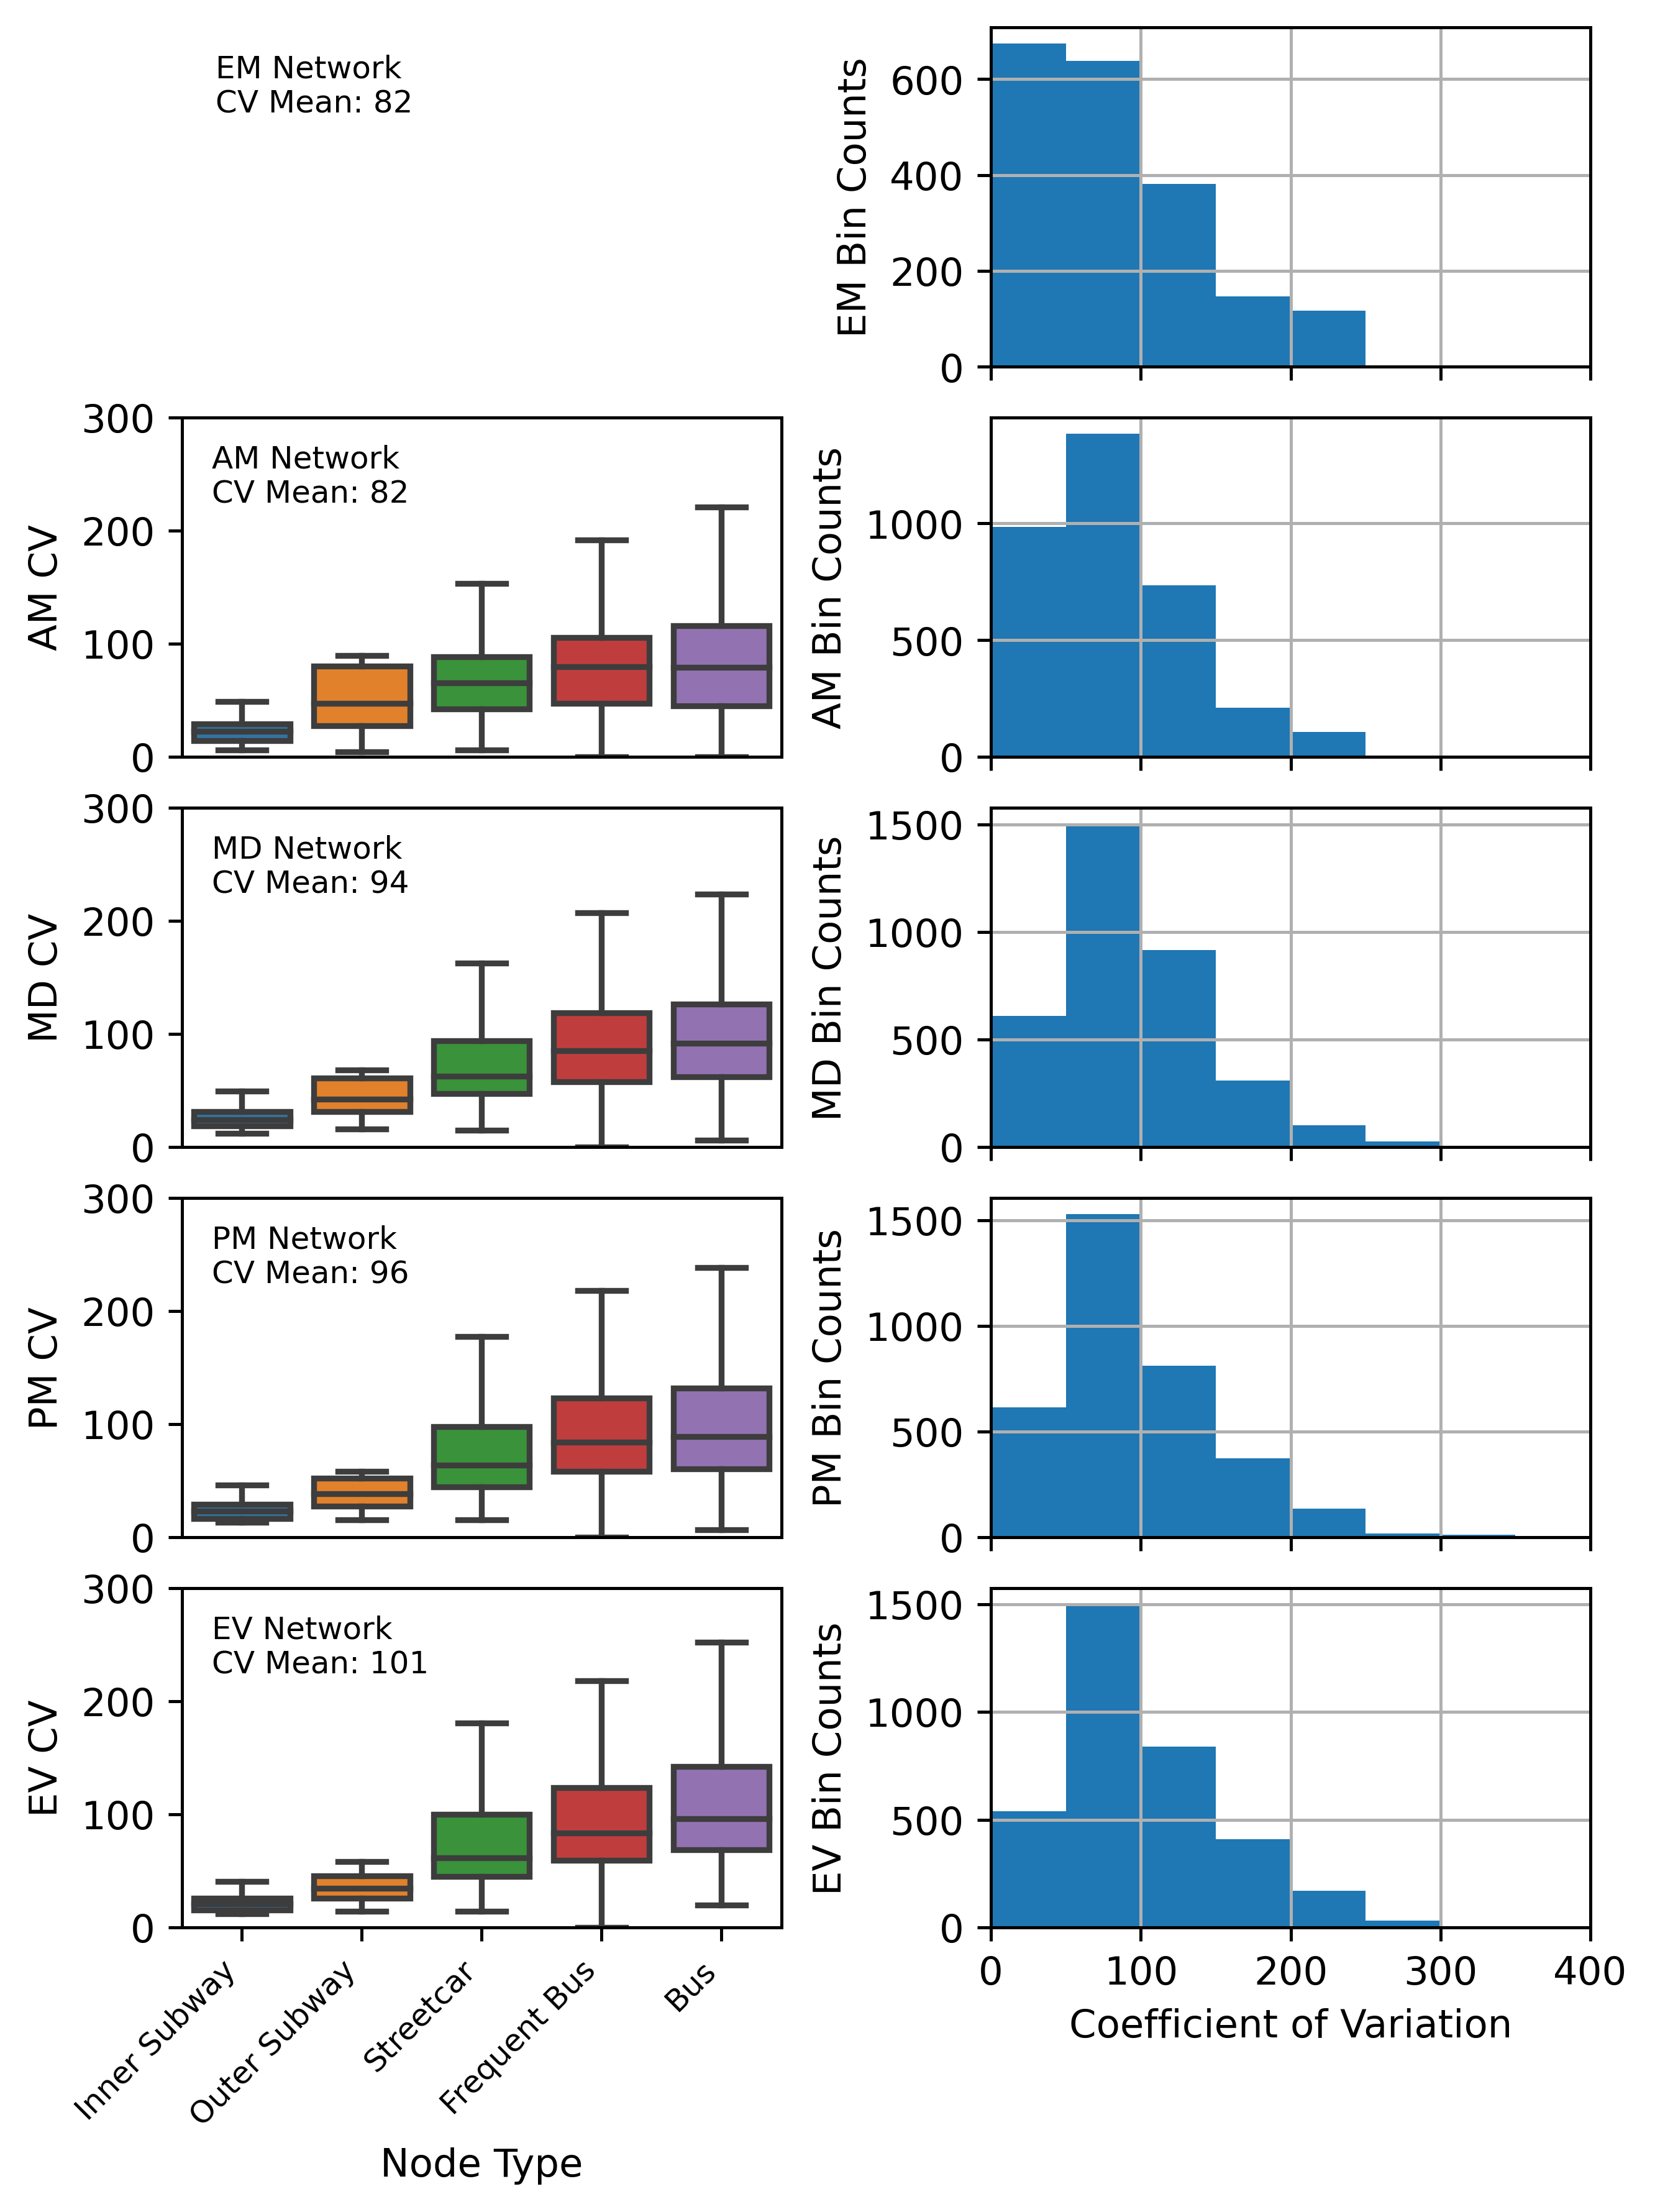

In [22]:
fig, ax = plt.subplots(5,2)

ax[0][0].axis('off')
ax[0][0].set_xlim([-0.5,4])
ax[0][0].set_ylim([0,300])
ax[0,0].text(-0.25,225, 'EM Network\nCV Mean: ' + str(round(bc_var_type[bc_var_type['period']=='EM']['cov'].mean())), fontsize = 8)

fig.set_size_inches(6.5,9)

i=1
for period in ['AM', 'MD', 'PM', 'EV']:
    
    sns.boxplot(x="node_type", y="cov", data = bc_var_type[bc_var_type['period']==period], ax=ax[i,0], 
                palette = 'tab10',   showfliers=False, order = ['Inner Subway', 'Outer Subway',
                                                                'Streetcar', 'Frequent Bus', 'Bus'])
    ax[i,0].set_xticks([])
    ax[i,0].set_xlabel(xlabel=None)
    ax[i,0].set_ylabel(period + ' CV')
    ax[i,0].set_ylim([0,300])
    ax[i,0].text(-0.25,225, period + ' Network\nCV Mean: ' + str(round(bc_var_type[bc_var_type['period']==period]['cov'].mean())), fontsize = 8)
    i = i + 1
    
ax[4,0].set_xticks(range(5))
ax[4,0].set_xticklabels(labels = ['Inner Subway', 'Outer Subway','Streetcar', 'Frequent Bus', 'Bus'],
                        fontsize = 8, rotation = 45, ha = 'right')

ax[4,0].set_xlabel('Node Type')


i=0
for period in ['EM', 'AM', 'MD', 'PM', 'EV']:
    bc_var_type[bc_var_type['period']==period]['cov'].hist(ax = ax[i,1], bins = [0,50,100,150,200,250,300,350,400])
    ax[i,1].set_xlim([0,400])
    ax[i,1].set_xticklabels([])
    ax[i,1].set_ylabel(period + ' Bin Counts')
    i = i + 1

ax[4,1].set_xticklabels(range(0,500,100))

ax[4,1].set_xlabel('Coefficient of Variation')
plt.subplots_adjust(wspace=0.35, hspace=0.15)

plt.savefig('bc_var.png', dpi = 300, bbox_inches = "tight")